# simple_XRD_jl.pynb
### by Hezy Amiel

January 2023

Julia 1.8.5

In [12]:
using Plots, SpecialFunctions, Random, Distributions, DataFrames, CSV

In [13]:
Random.seed!(347) # Setting the seed

TaskLocalRNG()

## Functions

In [14]:
function Gaussian(x, fwhm)
    σ = fwhm/(2√(2log(2)))
    return @. 1/√(2π)/σ * exp(-x^2/2σ^2)
end

Gaussian (generic function with 1 method)

In [15]:
function Lorentzian(x, fwhm)
    γ = fwhm / 2
    return @. (γ/pi) / (x^2 + γ^2)
end

Lorentzian (generic function with 1 method)

In [16]:
function Pseudo_Voigt(x, fwhm, n)
	return n * Lorentzian(x, fwhm) + (1 - n) * Gaussian(x, fwhm)
end

Pseudo_Voigt (generic function with 1 method)

In [17]:
function Voigt(x, fwhm_L, fwhm_G)
    γ = fwhm_L/2
    σ = fwhm_G/(2√(2log(2)))
    z = @. -im * (x + im * γ) / (√2 * σ)
    return @. real(erfcx(z)) / (√(2pi) * σ)
end

Voigt (generic function with 1 method)

In [18]:
function peak(θ, θ₀, A, w, n)
    return @. A * Pseudo_Voigt(θ-θ₀, w, n)
end

peak (generic function with 1 method)

In [19]:
function peaks_width(two_θ, U, V, W)
    #two_θ_rad = two_θ_deg * π/180
    return @. √(U * tand(two_θ/2)^2 + V * tand(two_θ/2) + W)
end

peaks_width (generic function with 1 method)

In [20]:
function bragg_angels(wavelength, d_spacings)
    sinθ = wavelength ./ (2*d_spacings)
    sinθ_cleaned = [item for item in sinθ if abs(item)<=1]  # removing values outside (-1,1), is this good???
    return 2 * (180/π) * asin.(sinθ_cleaned)  # *2 for 2θ  
end

bragg_angels (generic function with 1 method)

In [21]:
function d_list(indices, a)
    return a ./ .√(sum(indices.^2, dims=2))
end

d_list (generic function with 1 method)

In [22]:
function sum_peaks(θ, two_θ_list, U, V, W)
    y = zeros(size(θ))
    for item in two_θ_list
        y = y + peak(θ, item, 1, peaks_width(θ, U, V, W), 0.5)
    end
    return y
end


sum_peaks (generic function with 1 method)

In [23]:
function intensity_vs_angle(θ, indices, λ, a, U, V, W)
    indices = (reduce(hcat, indices))'
    two_θ_list = bragg_angels(λ, d_list(indices, a));
    y = sum_peaks(θ, two_θ_list, U, V, W)
    return y
end

intensity_vs_angle (generic function with 1 method)

In [24]:
function plot_it(θ, y, Title)
    p = plot(θ, y)
    title!(Title)
    xlabel!(raw"2θ (deg)")
    ylabel!(raw"Intensity (arb.)")
    return p
end

plot_it (generic function with 1 method)

In [25]:
function Miller_indices(cell_type, min, max)
    if cell_type == "SC"
        # In simple cubic lattince, all Miller indices are allowed
        return [
            [h, k, l] for h = min:max for k = min:max for
            l = min:max if [h, k, l] != [0, 0, 0]
        ]
    elseif cell_type == "BCC"
        # In body centerd cubic lattice, only indices with h+k+l=even are allowed
        return [
            [h, k, l] for h = min:max for k = min:max for
            l = min:max if iseven(h + k + l) && [h, k, l] != [0, 0, 0]
        ]
    elseif cell_type == "FCC"
        # In face centered cubic lattice, h,k,l must all be either odd or even
        return [
            [h, k, l] for h = min:max for k = min:max for l = min:max if
            ((iseven(h) && iseven(k) && iseven(l)) || (isodd(h) && isodd(k) && isodd(l))) &&
            [h, k, l] != [0, 0, 0]
        ]
    else
        return [0, 0, 0]
    end
end

Miller_indices (generic function with 1 method)

In [26]:
function background(θ)
    return @. 2 + θ*(360-θ)/15000
end

background (generic function with 1 method)

## General Settings

In [27]:
N = 1000   
θ = collect(LinRange(0, 180, N))
y = zeros(N)
λ = 0.15418  # CuKα radiation in nm
U, V, W = 0.2, 0.2, 0.2

(0.2, 0.2, 0.2)

### Lattice parameter for some elements (in Å)


#### SC lattice:

Po  0.3352


#### BCC lattice:

Fe  0.2856   ;   Mo  0.3142   ;   W   0.3155   ;   V   0.30399  ;   Nb  0.33008  ;   Ta  0.33058


#### FCC lattice:

Al  0.4046   ;   Ni  0.3499   ;   Cu  0.3594   ;   Pd  0.3859   ;   Ag  0.4079   ;   Pt  0.4920   ;   Au  0.4065   ;   Pb  0.4920


from https://en.wikipedia.org/wiki/Lattice_constant

## Simple Cubic

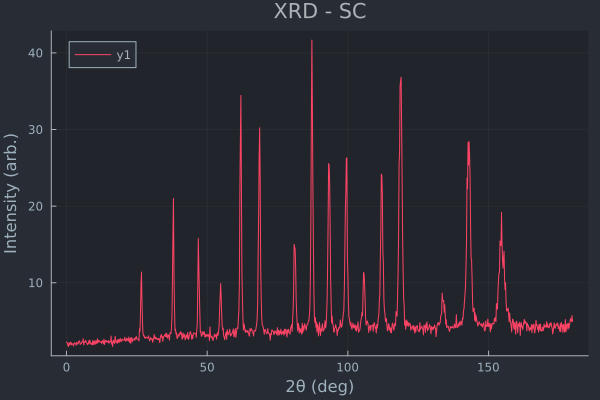

In [28]:
"""
Lattice parameter for SC Polonium (α-Po)
from https://en.wikipedia.org/wiki/Polonium 
"""
a_SC = 0.3352

indices_SC = Miller_indices("SC", -5, 5)

y_SC =
    (background(θ) + intensity_vs_angle(θ, indices_SC, λ, a_SC, U, V, W)) .*
    rand(Normal(1, 0.1), N)

plot_it(θ, y_SC, "XRD - SC")

## Body Centered Cubic

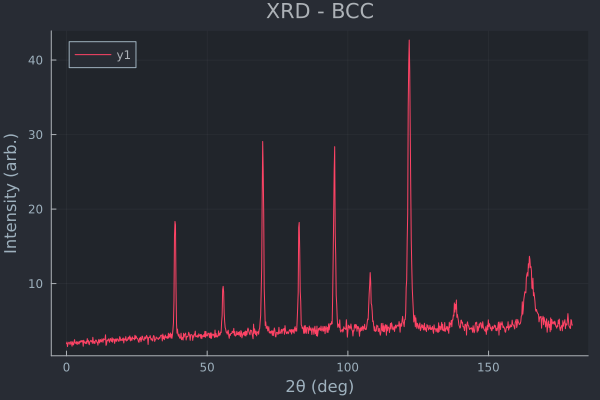

In [29]:
"""
Lattice parameter for BCC Nb
"""
a_BCC = 0.33008

indices_BCC = Miller_indices("BCC", -5, 5)

y_BCC =
    (background(θ) + intensity_vs_angle(θ, indices_BCC, λ, a_BCC, U, V, W)) .*
    rand(Normal(1, 0.1), N)
    
plot_it(θ, y_BCC, "XRD - BCC")

## Face Centered Cubic

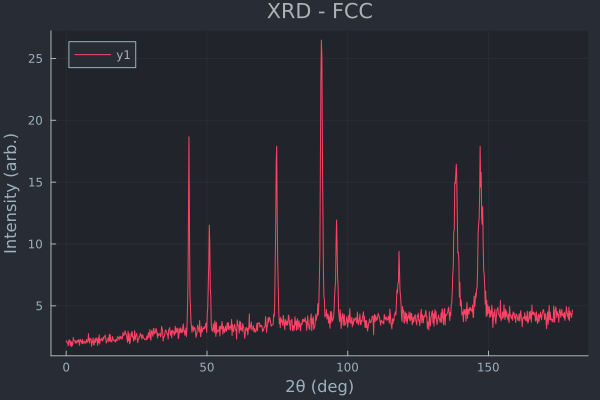

In [30]:
"""
Lattice parameter for FCC Cu
"""
a_FCC = 0.3594 

indices_FCC = Miller_indices("FCC", -5, 5)
                
y_FCC =
    (background(θ) + intensity_vs_angle(θ, indices_FCC, λ, a_FCC, U, V, W)) .*
    rand(Normal(1, 0.1), N)

plot_it(θ, y_FCC, "XRD - FCC")

In [31]:
df = DataFrame(angle = θ, SC = y_SC, BCC = y_BCC, FCC = y_FCC)

Row,angle,SC,BCC,FCC
,Float64,Float64,Float64,Float64
1,0.0,2.27089,1.93951,2.13112
2,0.18018,2.17708,2.15357,2.16685
3,0.36036,2.17012,1.54392,1.99265
4,0.540541,1.80168,1.91352,1.99663
5,0.720721,1.67348,2.02741,1.76465
6,0.900901,2.17075,2.14156,2.1532
7,1.08108,1.90286,2.03301,2.25521
8,1.26126,2.14683,1.82276,2.13442
9,1.44144,2.25245,2.06433,1.80749


In [32]:
CSV.write("XRD_results.csv", df)

"XRD_results.csv"